    This is a modified notebook for the project, from the sample code downloaded originally from MedMNIST example at https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb .

In [1]:
!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

# Device setup
# Check for CUDA
if torch.cuda.is_available():
	device = torch.device("cuda")
	print("Using CUDA (GPU)")

	
# Check for MPS (Apple Silicon Macs)
elif torch.backends.mps.is_available():
	device = torch.device("mps")
	print("Using MPS (macOS)")
	
else:
	device = torch.device("cpu")
	print("Using CPU")

# Example usage: Move model and tensors to the selected device

import medmnist
from medmnist import INFO, Evaluator

Using CUDA (GPU)


In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [48]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [50]:
DOWNLOAD_PATH = "D:\.medmnist"

In [156]:
# preprocessing
data_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(root = DOWNLOAD_PATH, split='train', transform=data_transform, download=download)
test_dataset = DataClass(root = DOWNLOAD_PATH, split='test', transform=data_transform, download=download)

pil_dataset = DataClass(root = DOWNLOAD_PATH, split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [8]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: D:\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K in

In [67]:
# visualization

train_dataset.montage(length=1)

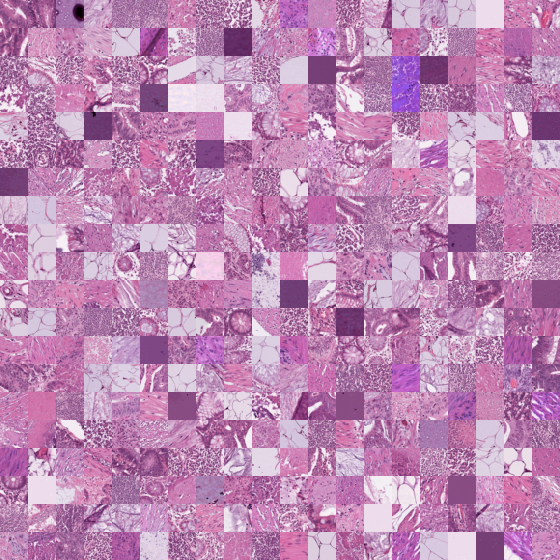

In [68]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [157]:
# define a simple CNN model

class Net(nn.Module):
	def __init__(self, in_channels, num_classes):
		super(Net, self).__init__()

		self.layer1 = nn.Sequential(
			nn.Conv2d(in_channels, 16, kernel_size=3),
			nn.BatchNorm2d(16),
			nn.ReLU())

		self.layer2 = nn.Sequential(
			nn.Conv2d(16, 16, kernel_size=3),
			nn.BatchNorm2d(16),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2))

		self.layer3 = nn.Sequential(
			nn.Conv2d(16, 64, kernel_size=3),
			nn.BatchNorm2d(64),
			nn.ReLU())

		self.layer4 = nn.Sequential(
			nn.Conv2d(64, 64, kernel_size=3),
			nn.BatchNorm2d(64),
			nn.ReLU())

		self.layer5 = nn.Sequential(
			nn.Conv2d(64, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2))

		self.fc = nn.Sequential(
			nn.Linear(64 * 4 * 4, 128),
			nn.ReLU(),
			nn.Linear(128, 128),
			nn.ReLU(),
			nn.Linear(128, num_classes))

	def forward(self, x):
		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		x = self.layer4(x)
		x = self.layer5(x)
		x = x.reshape(x.size(0), -1)
		x = self.fc(x)
		return x

model = Net(in_channels=n_channels, num_classes=n_classes).to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
	criterion = nn.BCEWithLogitsLoss()
else:
	criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [158]:
# train

for epoch in range(NUM_EPOCHS):
	train_correct = 0
	train_total = 0
	test_correct = 0
	test_total = 0
	
	model.train()
	for inputs, targets in tqdm(train_loader):
		# forward + backward + optimize
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = model(inputs)
		
		if task == 'multi-label, binary-class':
			targets = targets.to(torch.float32)
			loss = criterion(outputs, targets)
		else:
			targets = targets.squeeze().long()
			loss = criterion(outputs, targets)
		
		loss.backward()
		optimizer.step()

100%|██████████| 704/704 [00:10<00:00, 69.06it/s]


In [11]:
# evaluation

def test(split):
	model.eval()
	y_true = torch.tensor([], device=device)
	y_score = torch.tensor([], device=device)
	
	data_loader = train_loader_at_eval if split == 'train' else test_loader

	with torch.no_grad():
		for inputs, targets in data_loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)

			if task == 'multi-label, binary-class':
				targets = targets.to(torch.float32)
				outputs = outputs.softmax(dim=-1)
			else:
				targets = targets.squeeze().long()
				outputs = outputs.softmax(dim=-1)
				targets = targets.float().resize_(len(targets), 1)

			y_true = torch.cat((y_true, targets), 0)
			y_score = torch.cat((y_score, outputs), 0)

		y_true = y_true.cpu().numpy()
		y_score = y_score.cpu().detach().numpy()
		
		evaluator = Evaluator(data_flag, split)
		metrics = evaluator.evaluate(y_score)
	
		print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

		
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.972  acc:0.729
test  auc: 0.949  acc:0.577


# Shap load tool

In [159]:
## Dataloader to load the saved tensor instead for explainability experiments.
## Usage: 
# from torch.utils.data import DataLoader

# xai_dataset = SavedTensorDataset('./xai_data_28x28') # or xai_data_224 for the resnet experiment
# xai_loader = DataLoader(xai_dataset, batch_size=1, shuffle=False)

# for img_tensor, label in xai_loader:
#     # Use `img_tensor` for inference, saliency, etc.
#     print(img_tensor.shape, label.item())

import os
import torch
from torch.utils.data import Dataset


class SavedTensorDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = sorted([
            f for f in os.listdir(root_dir) if f.endswith(".pt")
        ])
        self.labels = [int(f.split('_')[1]) for f in self.file_list]  # from filename

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_list[idx])
        tensor = torch.load(file_path)
        label = self.labels[idx]
        return tensor, label

In [161]:
def get_sample_from_loader(loader, index):
    """Retrieve a single sample from DataLoader by index"""
    current_idx = 0
    device = next(model.parameters()).device
    for batch in loader:
        inputs, targets = batch
        batch_size = inputs.shape[0]
        if current_idx + batch_size > index:
            sample_idx = index - current_idx
            sample_img = inputs[sample_idx].unsqueeze(0).to(device)  # (1, C, H, W)
            sample_label = targets[sample_idx].item()
            return sample_img, sample_label
        current_idx += batch_size
    raise IndexError(f"Index {index} exceeds dataset size")


def get_samples_from_loader(loader, indices):
    """Retrieve multiple samples from DataLoader"""
    samples = []
    labels = []
    for ind in indices:
        img, label = get_sample_from_loader(loader, ind)
        samples.append(img)  # each img has shape (1, C, H, W)
        labels.append(label)
    samples = torch.cat(samples, dim=0)  # (N, C, H, W)
    return samples, labels



# Load Tensor of Image

In [165]:
root_dir = './xai_data_28x28'  
xai_dataset = SavedTensorDataset(root_dir)
xai_loader = data.DataLoader(xai_dataset, batch_size=1, shuffle=False)

In [166]:
import shap

label_mapping = info['label']
output_names = [label_mapping[str(i)] for i in range(len(label_mapping))]

ind = 4

# 获取待解释样本: shape = [1, C, H, W]
to_explain, label_explain = get_sample_from_loader(xai_loader, ind)
print("To explain shape:", to_explain.shape, "Label:", label_explain)

# 获取一批背景样本: shape = [N, C, H, W], N 可以是 50、100 等
bg_indices = range(0, len(xai_dataset))
gs, gs_labels = get_samples_from_loader(xai_loader, bg_indices)
print("Background dataset shape:", gs.shape)

# to_explain = to_explain.float().to(device)
# gs = gs.float().to(device)

To explain shape: torch.Size([1, 3, 28, 28]) Label: 2
Background dataset shape: torch.Size([18, 3, 28, 28])



Model Prediction Detail:
- Predicted Label: background
- Confidence: 95.60%

Class Probabilities:
  adipose: 0.06%
  background: 95.60%
  debris: 0.03%
  lymphocytes: 0.00%
  mucus: 4.29%
  smooth muscle: 0.00%
  normal colon mucosa: 0.01%
  cancer-associated stroma: 0.01%
  colorectal adenocarcinoma epithelium: 0.01%

True Label: debris


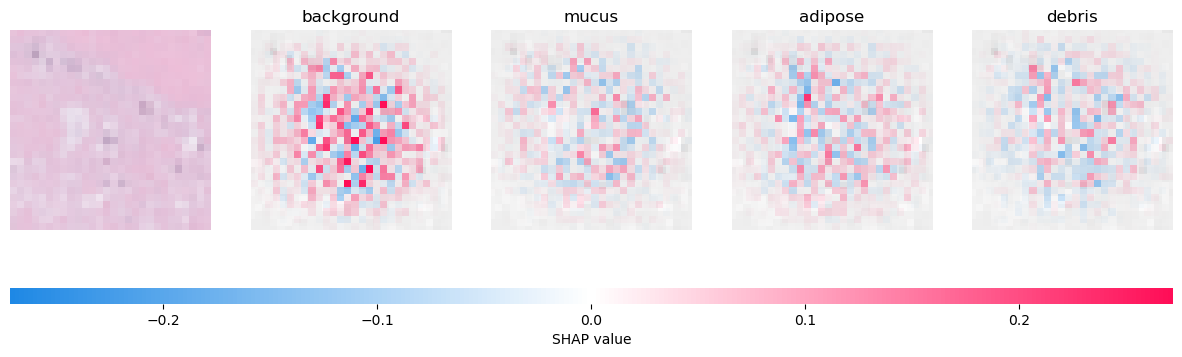

In [168]:
# ================== Prediction & Processing ==================
with torch.no_grad():
    prediction = model(to_explain)
    
    if task == 'multi-label, binary-class':
        probs = torch.sigmoid(prediction).squeeze().cpu().numpy()
        pred_label = (probs > 0.5).astype(int)
        # Get all activated tags
        activated_indices = np.where(pred_label == 1)[0]
    else:
        probs = torch.softmax(prediction, dim=1).squeeze().cpu().numpy()
        pred_label = np.argmax(probs)
        activated_indices = [pred_label] 
        
    top4_indices = np.argsort(probs)[-4:][::-1]  # Sort probabilities descending
    top4_probs = probs[top4_indices]
    top4_labels = [output_names[i] for i in top4_indices]

    print("\nModel Prediction Detail:")
    if task == 'multi-label, binary-class':
        activated_labels = [output_names[i] for i in activated_indices]
        activated_probs = [f"{probs[i]:.2%}" for i in activated_indices]
        print(f"- Predicted Labels: {activated_labels}")
        print(f"- Confidences: {', '.join(activated_probs)}")
    else:
        print(f"- Predicted Label: {output_names[pred_label]}")
        print(f"- Confidence: {probs[pred_label]:.2%}")

    print("\nClass Probabilities:")
    for name, prob in zip(output_names, probs):
        print(f"  {name}: {prob:.2%}")
        
to_explain = to_explain * 0.5 + 0.5

to_explain = to_explain.clamp(0, 1)

# Create the explainer
explainer = shap.GradientExplainer(model, gs)

# Compute SHAP values
shap_values, indexes = explainer.shap_values(to_explain, ranked_outputs=4, nsamples=300)

# Process SHAP values
shap_values = [np.transpose(s, (3, 1, 2, 0)) for s in shap_values]

# Process image data
pixel_values = to_explain.detach().cpu().numpy()
pixel_values = np.transpose(pixel_values, (0, 2, 3, 1))

pixel_values = pixel_values.astype(np.float32)
if pixel_values.max() > 1.0:
    pixel_values /= 255.0


indexes_np = indexes.detach().cpu().numpy()

# Prepare SHAP values list  
shap_values_list = [shap_values[0][i:i+1] for i in range(shap_values[0].shape[0])]

print(f"\nTrue Label: {output_names[label_explain]}")

index_names = np.vectorize(lambda x: label_mapping[str(x)])(indexes_np)

# all_class_names.shape = (batch_size, 4)
shap.image_plot(shap_values_list, pixel_values, labels=index_names)


# We then check a 2D dataset with size 224x224

In [124]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
# train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
train_dataset = DataClass(root = DOWNLOAD_PATH, split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(root = DOWNLOAD_PATH, split='test', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

RuntimeError: 
                Automatic download failed! Please download pathmnist_224.npz manually.
                1. [Optional] Check your network connection: 
                    Go to https://github.com/MedMNIST/MedMNIST/ and find the Zenodo repository
                2. Download the npz file from the Zenodo repository or its Zenodo data link: 
                    https://zenodo.org/records/10519652/files/pathmnist_224.npz?download=1
                3. [Optional] Verify the MD5: 
                    2c51a510bcdc9cf8ddb2af93af1eadec
                4. Put the npz file under your MedMNIST root folder: 
                    D:\.medmnist
                

In [34]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 224 (pathmnist_224)
    Number of datapoints: 89996
    Root location: D:\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-10

In [12]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([3, 224, 224]) (1,)


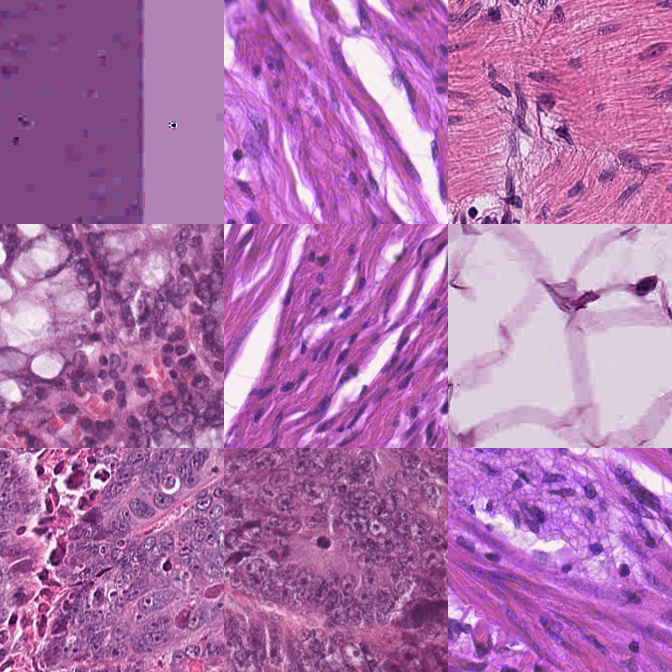

In [16]:
train_dataset.montage(length=3)

## Then we train and evaluate on this 224x224 dataset

In [169]:
from torchvision.models import resnet34

model = resnet34(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
	
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [18]:
# train

for epoch in range(NUM_EPOCHS):
	train_correct = 0
	train_total = 0
	test_correct = 0
	test_total = 0
	
	model.train()
	for inputs, targets in tqdm(train_loader):
		# forward + backward + optimize 
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = model(inputs)
		
		if task == 'multi-label, binary-class':
			targets = targets.to(torch.float32)
			loss = criterion(outputs, targets)
		else:
			targets = targets.squeeze().long()
			loss = criterion(outputs, targets)
		
		loss.backward()
		optimizer.step()
		
torch.save(model.state_dict(), 'trained_model.pth')

100%|██████████| 704/704 [04:36<00:00,  2.55it/s]


## Load Model ##

In [170]:
model = resnet34(num_classes=n_classes).to(device)
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# evaluation

def test(split):
	model.eval()
	y_true = torch.tensor([], device=device)
	y_score = torch.tensor([], device=device)
	
	data_loader = train_loader_at_eval if split == 'train' else test_loader

	with torch.no_grad():
		for inputs, targets in data_loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)

			if task == 'multi-label, binary-class':
				targets = targets.to(torch.float32)
				outputs = outputs.softmax(dim=-1)
			else:
				targets = targets.squeeze().long()
				outputs = outputs.softmax(dim=-1)
				targets = targets.float().resize_(len(targets), 1)

			y_true = torch.cat((y_true, targets), 0)
			y_score = torch.cat((y_score, outputs), 0)

		y_true = y_true.cpu().numpy()
		y_score = y_score.cpu().detach().numpy()
		
		evaluator = Evaluator(data_flag, split)
		metrics = evaluator.evaluate(y_score)
	
		print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
		
		
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.997  acc:0.899
test  auc: 0.972  acc:0.772


# Load Image For Shap

In [171]:
root_dir = './xai_data_224'  
xai_dataset = SavedTensorDataset(root_dir)
xai_loader = data.DataLoader(xai_dataset, batch_size=1, shuffle=False)


Model Prediction Detail:
- Predicted Label: debris
- Confidence: 99.81%

Class Probabilities:
  adipose: 0.00%
  background: 0.00%
  debris: 99.81%
  lymphocytes: 0.05%
  mucus: 0.00%
  smooth muscle: 0.00%
  normal colon mucosa: 0.06%
  cancer-associated stroma: 0.06%
  colorectal adenocarcinoma epithelium: 0.02%


PartitionExplainer explainer: 2it [00:20, 20.80s/it]               



True Label: debris


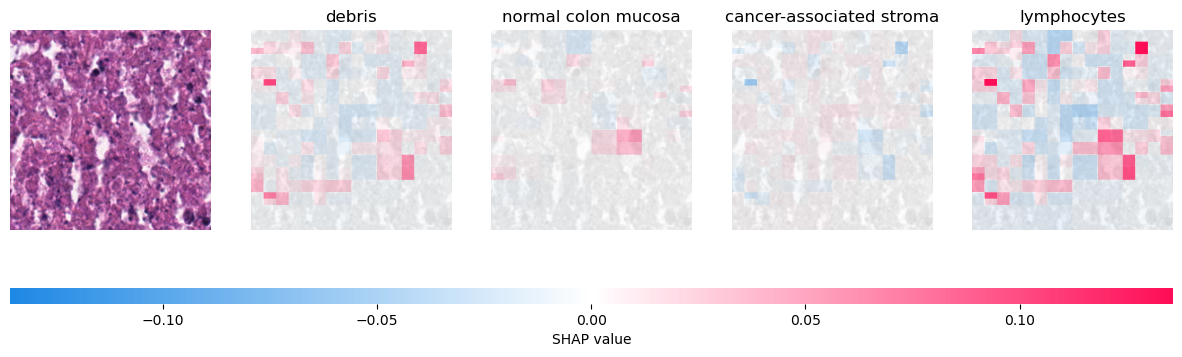

In [174]:
import shap
import torch
import numpy as np

# Label mapping configuration
label_mapping = info['label']
output_names = [label_mapping[str(i)] for i in range(len(label_mapping))]


# Retrieve sample
ind = 4

sample_img, true_label = get_sample_from_loader(xai_loader, ind)


# ================== Prediction & Processing ==================
with torch.no_grad():
    prediction = model(sample_img)
    
    if task == 'multi-label, binary-class':
        probs = torch.sigmoid(prediction).squeeze().cpu().numpy()
        pred_label = (probs > 0.5).astype(int)
        # Get all activated tags
        activated_indices = np.where(pred_label == 1)[0]
    else:
        probs = torch.softmax(prediction, dim=1).squeeze().cpu().numpy()
        pred_label = np.argmax(probs)
        activated_indices = [pred_label] 
        
    top4_indices = np.argsort(probs)[-4:][::-1]  # Sort probabilities descending
    top4_probs = probs[top4_indices]
    top4_labels = [output_names[i] for i in top4_indices]

    print("\nModel Prediction Detail:")
    if task == 'multi-label, binary-class':
        activated_labels = [output_names[i] for i in activated_indices]
        activated_probs = [f"{probs[i]:.2%}" for i in activated_indices]
        print(f"- Predicted Labels: {activated_labels}")
        print(f"- Confidences: {', '.join(activated_probs)}")
    else:
        print(f"- Predicted Label: {output_names[pred_label]}")
        print(f"- Confidence: {probs[pred_label]:.2%}")

    print("\nClass Probabilities:")
    for name, prob in zip(output_names, probs):
        print(f"  {name}: {prob:.2%}")

# ================== SHAP Core Explanation ==================
def f(x):
    """Wrapper for SHAP model compatibility"""
    tmp = torch.tensor(x, dtype=torch.float32)
    if tmp.shape[-1] == 3:
        tmp = tmp.permute(0, 3, 1, 2)
    tmp = tmp.to(next(model.parameters()).device)
    return model(tmp)


sample_img = sample_img * 0.5 + 0.5

# 使用 PyTorch clamp，而非 np.clip
sample_img = sample_img.clamp(0, 1)

# Masker creation and explainer configuration
masker = shap.maskers.Image("inpaint_telea", 
                            sample_img.squeeze(0).permute(1, 2, 0).shape)

explainer = shap.Explainer(
    f, 
    masker, 
    output_names=output_names,
    algorithm="partition",
    segmentation_fn=lambda x: slic(x, n_segments=10000, compactness=20)
)

shap_values_ = explainer(
    sample_img.permute(0, 2, 3, 1).cpu().numpy(),
    max_evals=1000,
    batch_size=50,
    outputs=top4_indices  # Key: bind to top-4 output nodes
)

# Alternative call to explain activated classes (optional)
# shap_values_ = explainer(
#     sample_img.permute(0, 2, 3, 1).cpu().numpy(),
#     max_evals=1500,
#     batch_size=32,
#     outputs=activated_indices  
# )

# 反归一化: x = x * 0.5 + 0.5




print(f"\nTrue Label: {output_names[true_label]}")
shap.image_plot(shap_values_)



Sample index 16 - Predicted label: colorectal adenocarcinoma epithelium
Confidence: 95.46%
Class probabilities:
  adipose: 0.00%
  background: 0.00%
  debris: 0.00%
  lymphocytes: 0.07%
  mucus: 0.00%
  smooth muscle: 0.00%
  normal colon mucosa: 4.47%
  cancer-associated stroma: 0.00%
  colorectal adenocarcinoma epithelium: 95.46%


PartitionExplainer explainer: 2it [00:20, 20.45s/it]               


Sample index 16 - True label: colorectal adenocarcinoma epithelium


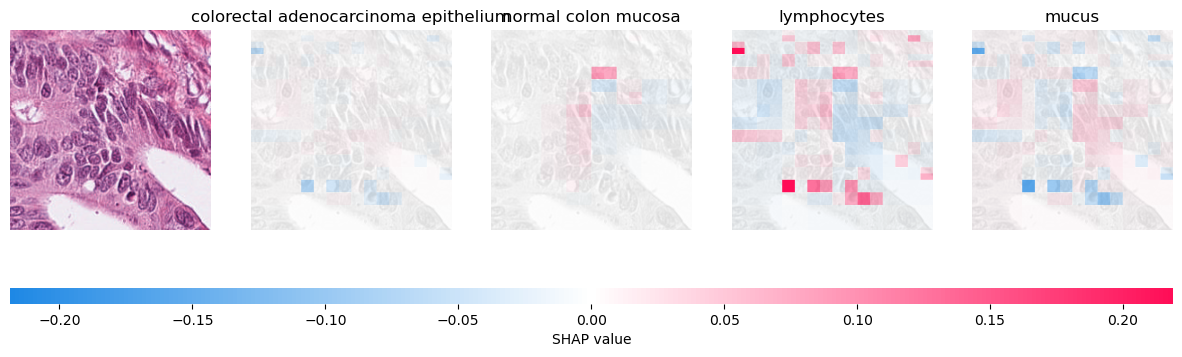


Sample index 17 - Predicted label: colorectal adenocarcinoma epithelium
Confidence: 99.95%
Class probabilities:
  adipose: 0.00%
  background: 0.00%
  debris: 0.00%
  lymphocytes: 0.04%
  mucus: 0.00%
  smooth muscle: 0.00%
  normal colon mucosa: 0.01%
  cancer-associated stroma: 0.00%
  colorectal adenocarcinoma epithelium: 99.95%


PartitionExplainer explainer: 2it [00:20, 20.61s/it]               


Sample index 17 - True label: colorectal adenocarcinoma epithelium


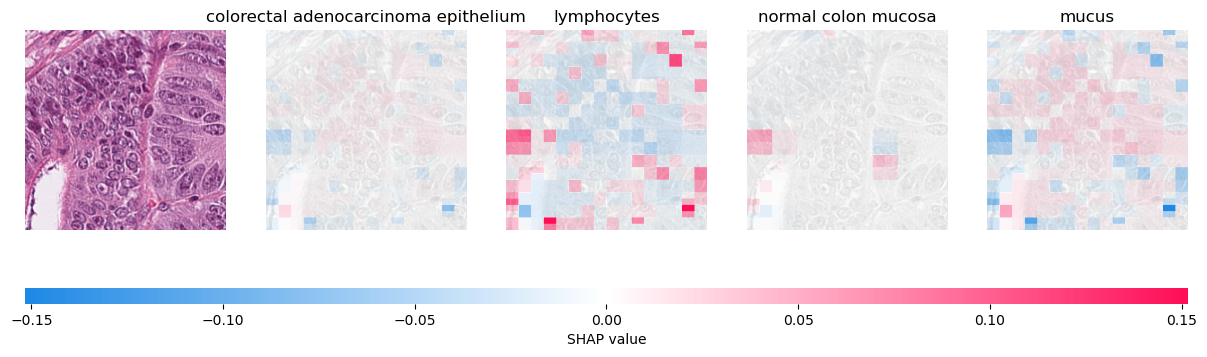

In [173]:
import shap
import torch
import numpy as np
from skimage.segmentation import slic  # Make sure scikit-image is installed


# Label mapping configuration
label_mapping = info['label']
output_names = [label_mapping[str(i)] for i in range(len(label_mapping))]


# Select multiple samples 
sample_indices = [16 , 17]
sample_imgs, true_labels = get_samples_from_loader(xai_loader, sample_indices)


# Batch prediction (for printing probabilities only)
with torch.no_grad():
    predictions = model(sample_imgs)

def f(x):
    """Wrapper function for SHAP model compatibility"""
    tmp = torch.tensor(x, dtype=torch.float32)
    if tmp.shape[-1] == 3:
        tmp = tmp.permute(0, 3, 1, 2)
    tmp = tmp.to(next(model.parameters()).device)
    return model(tmp)

sample_imgs = sample_imgs * 0.5 + 0.5

# 使用 PyTorch clamp，而非 np.clip
sample_imgs = sample_imgs.clamp(0, 1)

# Build masker using the shape (H, W, C) of the first sample
masker = shap.maskers.Image("inpaint_telea", sample_imgs[0].permute(1, 2, 0).shape)

# Configure SHAP explainer
explainer = shap.Explainer(
    f,
    masker,
    output_names=output_names,
    algorithm="partition",
    segmentation_fn=lambda x: slic(x, n_segments=1000, compactness=20)
)

# Compute and display SHAP explanations for top 4 predicted classes per sample
for i in range(len(sample_indices)):
    sample = sample_imgs[i].unsqueeze(0)  # (1, C, H, W)

    # Choose probability computation method based on task type
    if task == 'multi-label, binary-class':
        prob = torch.sigmoid(predictions[i]).squeeze().cpu().numpy()
        top4_indices = np.argsort(prob)[-4:][::-1]
        activated_indices = np.where((prob > 0.5).astype(int)==1)[0]
        print(f"\nSample index {sample_indices[i]} - Activated labels: {[output_names[j] for j in activated_indices]}")
    else:
        prob = torch.softmax(predictions[i], dim=0).squeeze().cpu().numpy()
        pred_label = np.argmax(prob)
        top4_indices = np.argsort(prob)[-4:][::-1]
        print(f"\nSample index {sample_indices[i]} - Predicted label: {output_names[pred_label]}")
        print(f"Confidence: {prob[pred_label]:.2%}")

    print("Class probabilities:")
    for name, p in zip(output_names, prob):
        print(f"  {name}: {p:.2%}")

    # Compute SHAP values only for top 4 classes
    shap_values_sample = explainer(
        sample.permute(0, 2, 3, 1).cpu().numpy(),
        max_evals=1000,
        batch_size=50,
        outputs=top4_indices
    )

    print(f"Sample index {sample_indices[i]} - True label: {output_names[true_labels[i]]}")
    shap.image_plot(shap_values_sample)


In [ ]:
### Currently the project scope ends here. The following is from the original sample and remains unchanged.

# We then check a 3D dataset with size 28x28x28

In [21]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 32.7M/32.7M [00:01<00:00, 18.7MB/s]


In [22]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [23]:
for x, y in train_loader:
	print(x.shape, y.shape)
	break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [24]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

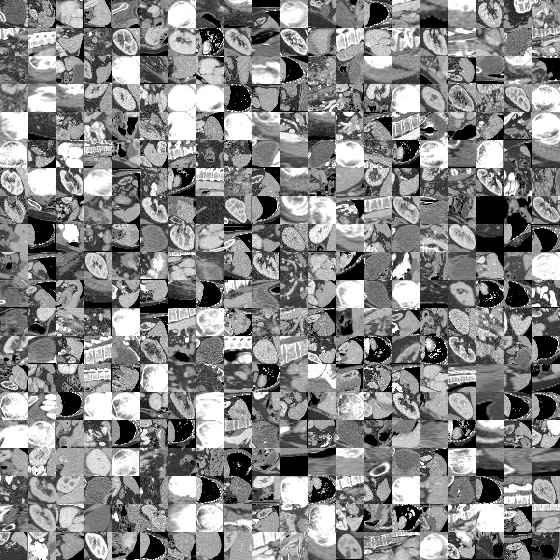

In [25]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_train_montage.gif) ;)

# We then check a 3D dataset with size 64x64x64

In [26]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 361M/361M [00:12<00:00, 29.3MB/s] 


In [27]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 64, 64, 64) (1,)


In [28]:
for x, y in train_loader:
	print(x.shape, y.shape)
	break

torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1])


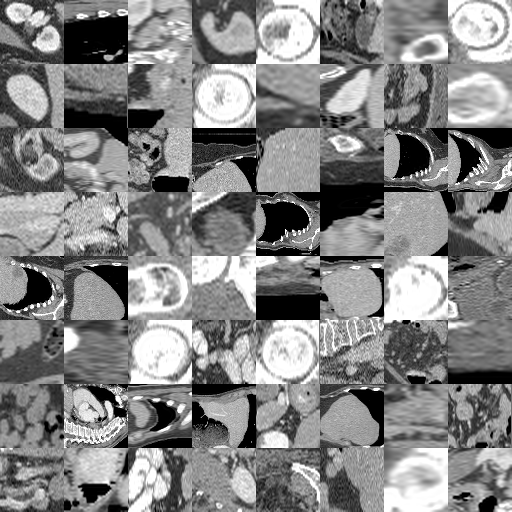

In [29]:
frames = train_dataset.montage(length=8, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_64_train_montage.gif) ;)

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)